# M4 — Survival Item Analysis Refinement
## Mika Ismayilli

## Warning Flood Fix (Fix the mess in the code outputs)

In [5]:
import warnings
warnings.filterwarnings("ignore")

import warnings
warnings.filterwarnings("ignore", message="datetime\\.datetime\\.utcnow\\(\\) is deprecated", category=DeprecationWarning)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## Load Dataset

In [6]:
# Import libraries
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import seaborn as sns

#Load data
episodes_url = "https://drive.google.com/uc?export=download&id=1Q2s1TZAl1epx_-hi8yXWQv12UJGt_LYe"
episodes_data = pd.read_csv(episodes_url)
loadouts_url = "https://drive.google.com/uc?export=download&id=1xym94LM-MIvEWI-IauIJViR4mXaqMiB0"
loadouts_data = pd.read_csv(loadouts_url)
seasons_url = "https://drive.google.com/uc?export=download&id=1M1cEpgPXD1PTLywN2JD7Dn8-QEWcUfWQ"
seasons_data = pd.read_csv(seasons_url)
survivalists_url = "https://drive.google.com/uc?export=download&id=1L600G_6QA1XVZGKl3Ky5AC9FWC4Uu3po"
survivalists_data = pd.read_csv(survivalists_url)

# View first few rows
print(episodes_data.head())
print(loadouts_data.head())
print(seasons_data.head())
print(survivalists_data.head())

  version  season  episode_number_overall  episode               title  \
0      US       1                       1        1    And So It Begins   
1      US       1                       2        2     Of Wolf and Man   
2      US       1                       3        3  The Talons of Fear   
3      US       1                       4        4             Stalked   
4      US       1                       5        5       Winds of Hell   

     air_date  viewers                                              quote  \
0  2015-06-18    1.582  I went to the woods because I wished to live d...   
1  2015-06-25    1.697  If you live among wolves you have to act like ...   
2  2015-07-02    1.864  Extinction is the rule. Survival is the except...   
3  2015-07-09    2.082  Hunger, love, pain, fear are some of those inn...   
4  2015-07-16    2.082    The strong survive, but the courageous triumph.   

                author  imdb_rating  n_ratings  
0  Henry David Thoreau          7.5      13

## Data Preprocessing

In [7]:
# Standardize column names
def standardize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("[", "", regex=False)
        .str.replace("]", "", regex=False))
    return df

loadouts = standardize_columns(loadouts_data)
survivalists = standardize_columns(survivalists_data)

# Merge loadouts with contestant outcomes for later interpretation
df = loadouts.merge(
    survivalists[['season','name','days_lasted','medically_evacuated','reason_category','gender','age']],
    on=['season','name'],
    how='left')

print("Merged data shape:", df.shape)
print("\nMissing values:")
print(df.isna().mean().sort_values(ascending=False).head())

Merged data shape: (940, 11)

Missing values:
reason_category    0.106383
season             0.000000
version            0.000000
name               0.000000
item_number        0.000000
dtype: float64


In [8]:
# Create basket format (binary matrix)
# Each row = one contestant's loadout
# Each column = one item type
# Values = 1 if item present, 0 if not

basket = (df.assign(val=1).pivot_table(index=['season','name'],columns='item',values='val',aggfunc='max',fill_value=0))

print("Basket dimensions:", basket.shape)
print(f"Number of contestants: {basket.shape[0]}")
print(f"Number of unique items: {basket.shape[1]}")
print("\nBasket preview:")
display(basket.head(10))

Basket dimensions: (94, 27)
Number of contestants: 94
Number of unique items: 27

Basket preview:


item                     Axe  Bivy bag  Bow and arrows  Canteen  Ferro rod  \
season name                                                                  
1      Alan Kay            1         0               0        1          1   
       Brant McGee         1         0               1        0          1   
       Chris Weatherman    1         0               1        1          1   
       Dustin Feher        1         0               0        1          1   
       Joe Robinet         1         0               0        0          1   
       Josh Chavez         1         0               1        0          1   
       Lucas Miller        1         0               0        0          1   
       Mitch Mitchell      1         1               1        0          1   
       Sam Larson          1         0               1        0          1   
       Wayne Russell       1         0               0        0          1   

item                     Fishing gear  Frying pan  Gillnet  Ground sheet  \
season name                                                                
1      Alan Kay                     1           0        1             0   
       Brant McGee                  1           0        0             0   
       Chris Weatherman             1           0        0             0   
       Dustin Feher                 1           0        1             0   
       Joe Robinet                  1           0        1             0   
       Josh Chavez                  1           0        0             1   
       Lucas Miller                 1           0        0             0   
       Mitch Mitchell               1           0        1             0   
       Sam Larson                   1           0        0             0   
       Wayne Russell                1           0        0             1   

item                     Hammock  ...  Saw  Scotch eyed auger  \
season name                       ...                           
1      Alan Kay                0  ...    1                  0   
       Brant McGee             0  ...    0                  0   
       Chris Weatherman        0  ...    1                  0   
       Dustin Feher            0  ...    0                  0   
       Joe Robinet             0  ...    0                  0   
       Josh Chavez             0  ...    1                  0   
       Lucas Miller            0  ...    1                  0   
       Mitch Mitchell          0  ...    0                  0   
       Sam Larson              0  ...    0                  0   
       Wayne Russell           0  ...    1                  0   

item                     Sharpening stone  Shovel  Sleeping bag  Slingshot  \
season name                                                                  
1      Alan Kay                         0       0             1          0   
       Brant McGee                      0       0             1          0   
       Chris Weatherman                 1       0             1          0   
       Dustin Feher                     0       0             1          1   
       Joe Robinet                      0       0             1          0   
       Josh Chavez                      0       0             1          0   
       Lucas Miller                     0       0             1          0   
       Mitch Mitchell                   1       0             1          0   
       Sam Larson                       0       0             1          1   
       Wayne Russell                    0       0             1          0   

item                     Soap  Tarp  Trapping wire  Wire  
season name                                               
1      Alan Kay             0     0              0     1  
       Brant McGee          0     1              0     0  
       Chris Weatherman     0     0              0     0  
       Dustin Feher         0     0              0     0  
       Joe Robinet          0     1              0     0  
       Josh Chavez 

## Preprocessing

In [9]:
basket = (df.assign(val=1).pivot_table(index=['season','name'], columns='item', values='val', aggfunc='max', fill_value=0))

# Attach outcomes for later interpretation
outcomes = (survivalists.set_index(['season','name'])
[['days_lasted','medically_evacuated','reason_category','gender','age']])

X = basket.join(outcomes, how='left')


## EDA Item Frequencies

In [10]:
# Calculate item frequencies
item_freq = basket.sum(axis=0).sort_values(ascending=False)
item_pct = (item_freq / len(basket) * 100).round(2)

freq_df = pd.DataFrame({
    'item': item_freq.index,
    'count': item_freq.values,
    'percent': item_pct.values})

print("Top 10 Most Popular Items:")
display(freq_df.head(10))

print("\nBottom 10 Least Popular Items:")
display(freq_df.tail(10))

Top 10 Most Popular Items:


,item,count,percent
0,Fishing gear,90,95.74
1,Pot,90,95.74
2,Sleeping bag,82,87.23
3,Axe,80,85.11
4,Saw,78,82.98
5,Ferro rod,77,81.91
6,Bow and arrows,60,63.83
7,Paracord,56,59.57
8,Rations,55,58.51
9,Knife,50,53.19



Bottom 10 Least Popular Items:


,item,count,percent
17,Sharpening stone,4,4.26
18,Wire,3,3.19
19,Slingshot,3,3.19
20,Ground sheet,2,2.13
21,Hammock,2,2.13
22,Salt,2,2.13
23,Soap,2,2.13
24,Rope,1,1.06
25,Scotch eyed auger,1,1.06
26,Shovel,1,1.06


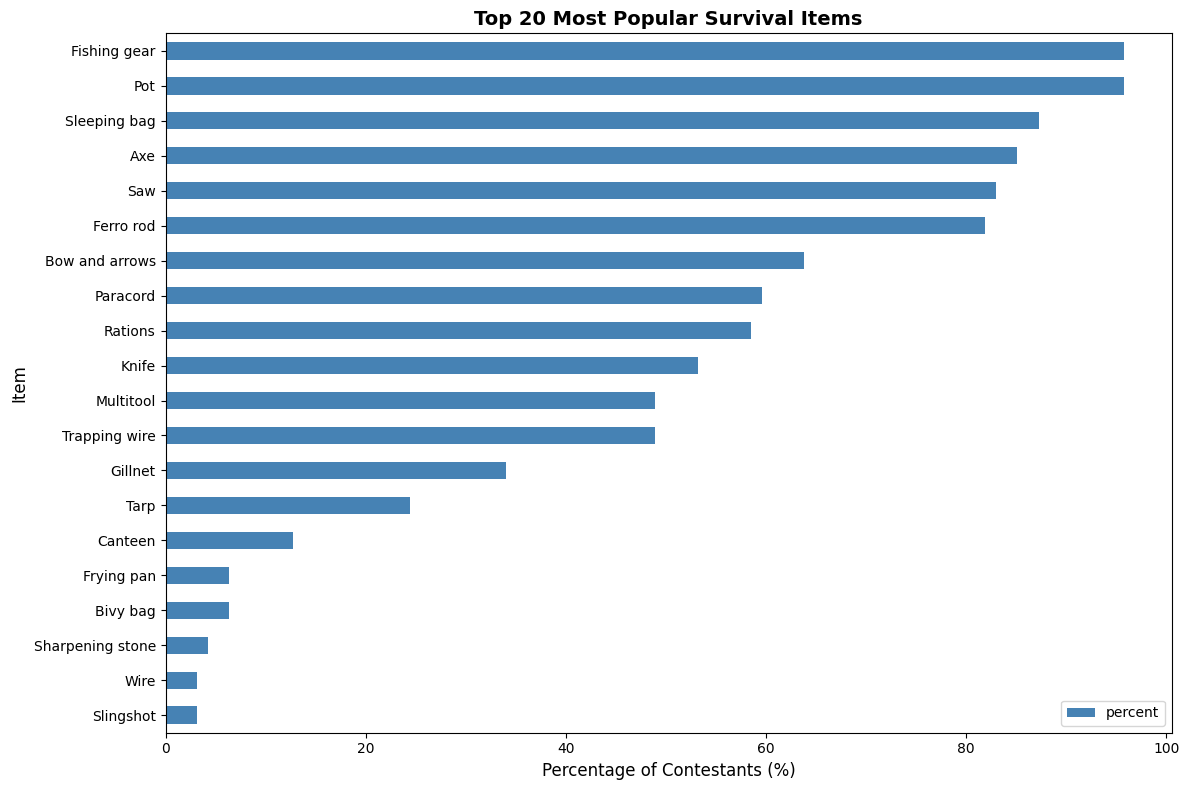

In [11]:
# Visualizing this
fig, ax = plt.subplots(figsize=(12, 8))
freq_df.head(20).plot(x='item', y='percent', kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Percentage of Contestants (%)', fontsize=12)
ax.set_ylabel('Item', fontsize=12)
ax.set_title('Top 20 Most Popular Survival Items', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Apriori Algorithm

For this, I decided to go with the following threshholds:
1. **Low threshold (0.10)**: Captures rare but potentially interesting combinations
2. **Medium threshold (0.20)**: Balanced view of moderately common patterns
3. **High threshold (0.30)**: Only very common, core strategies

In [12]:
# Apriori with low minimum support
frequent_itemsets_low = apriori(basket, min_support=0.10, use_colnames=True)
frequent_itemsets_low['length'] = frequent_itemsets_low['itemsets'].apply(lambda x: len(x))

print(f"Total frequent itemsets found: {len(frequent_itemsets_low)}")
print(f"\nItemsets by size:")
print(frequent_itemsets_low.groupby('length').size())

print("\nTop 10 frequent itemsets (by support):")
display(frequent_itemsets_low.sort_values('support', ascending=False).head(10))

Total frequent itemsets found: 2068

Itemsets by size:
length
1      15
2      89
3     272
4     499
5     564
6     393
7     174
8      51
9      10
10      1
dtype: int64

Top 10 frequent itemsets (by support):


,support,itemsets,length
9,0.957447,(Pot),1
4,0.957447,(Fishing gear),1
57,0.925532,"(Fishing gear, Pot)",2
12,0.872340,(Sleeping bag),1
0,0.851064,(Axe),1
92,0.829787,"(Sleeping bag, Pot)",2
60,0.829787,"(Sleeping bag, Fishing gear)",2
11,0.829787,(Saw),1
51,0.819149,"(Sleeping bag, Ferro rod)",2
17,0.819149,"(Axe, Fishing gear)",2


In [13]:
# Apriori with medium minimum support
frequent_itemsets_med = apriori(basket, min_support=0.20, use_colnames=True)
frequent_itemsets_med['length'] = frequent_itemsets_med['itemsets'].apply(lambda x: len(x))

print(f"Total frequent itemsets found: {len(frequent_itemsets_med)}")
print(f"\nItemsets by size:")
print(frequent_itemsets_med.groupby('length').size())

print("\nTop 10 frequent itemsets (by support):")
display(frequent_itemsets_med.sort_values('support', ascending=False).head(10))

Total frequent itemsets found: 1176

Itemsets by size:
length
1     14
2     76
3    204
4    324
5    321
6    183
7     50
8      4
dtype: int64

Top 10 frequent itemsets (by support):


,support,itemsets,length
3,0.957447,(Fishing gear),1
8,0.957447,(Pot),1
51,0.925532,"(Fishing gear, Pot)",2
11,0.872340,(Sleeping bag),1
0,0.851064,(Axe),1
54,0.829787,"(Sleeping bag, Fishing gear)",2
80,0.829787,"(Sleeping bag, Pot)",2
10,0.829787,(Saw),1
16,0.819149,"(Axe, Fishing gear)",2
2,0.819149,(Ferro rod),1


In [14]:
# Apriori with high minimum support (0.30)
frequent_itemsets_high = apriori(basket, min_support=0.30, use_colnames=True)
frequent_itemsets_high['length'] = frequent_itemsets_high['itemsets'].apply(lambda x: len(x))

print(f"Total frequent itemsets found: {len(frequent_itemsets_high)}")
print(f"\nItemsets by size:")
print(frequent_itemsets_high.groupby('length').size())

print("\nTop 10 frequent itemsets (by support):")
display(frequent_itemsets_high.sort_values('support', ascending=False).head(10))

Total frequent itemsets found: 494

Itemsets by size:
length
1     13
2     62
3    145
4    166
5     91
6     17
dtype: int64

Top 10 frequent itemsets (by support):


,support,itemsets,length
3,0.957447,(Fishing gear),1
8,0.957447,(Pot),1
47,0.925532,"(Fishing gear, Pot)",2
11,0.872340,(Sleeping bag),1
0,0.851064,(Axe),1
68,0.829787,"(Sleeping bag, Pot)",2
50,0.829787,"(Sleeping bag, Fishing gear)",2
10,0.829787,(Saw),1
2,0.819149,(Ferro rod),1
41,0.819149,"(Sleeping bag, Ferro rod)",2


## Association Rules

In [15]:
# Generate association rules from medium support itemsets
rules = association_rules(frequent_itemsets_med, metric="confidence",min_threshold=0.7)

# Filter by lift > 1.0
rules = rules[rules['lift'] > 1.2]

# Sort by lift (descending)
rules = rules.sort_values('lift', ascending=False)

print(f"Total rules generated: {len(rules)}")
print(f"\nRule metrics summary:")
print(rules[['support', 'confidence', 'lift']].describe())

Total rules generated: 2720

Rule metrics summary:
           support   confidence         lift
count  2720.000000  2720.000000  2720.000000
mean      0.250962     0.783592     1.487212
std       0.040022     0.066889     0.208231
min       0.202128     0.700000     1.200269
25%       0.212766     0.730769     1.320562
50%       0.244681     0.769231     1.450617
75%       0.276596     0.821429     1.631152
max       0.446809     1.000000     2.160920


In [16]:
print("Top 15 Association Rules (by Lift)")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15))

Top 15 Association Rules (by Lift)


,antecedents,consequents,support,confidence,lift
10002,"(Ferro rod, Fishing gear, Bow and arrows, Mult...","(Sleeping bag, Trapping wire, Axe, Pot)",0.234043,0.758621,2.160920
10015,"(Sleeping bag, Fishing gear, Bow and arrows, M...","(Ferro rod, Trapping wire, Axe, Pot)",0.234043,0.733333,2.154167
9975,"(Ferro rod, Pot, Fishing gear, Axe, Trapping w...","(Sleeping bag, Bow and arrows, Multitool)",0.234043,0.733333,2.154167
9996,"(Pot, Sleeping bag, Fishing gear, Axe, Trappin...","(Ferro rod, Bow and arrows, Multitool)",0.234043,0.709677,2.151925
10028,"(Ferro rod, Bow and arrows, Multitool)","(Pot, Sleeping bag, Fishing gear, Axe, Trappin...",0.234043,0.709677,2.151925
8493,"(Ferro rod, Fishing gear, Bow and arrows, Mult...","(Sleeping bag, Axe, Trapping wire)",0.244681,0.793103,2.130049
8503,"(Sleeping bag, Fishing gear, Bow and arrows, M...","(Ferro rod, Axe, Trapping wire)",0.244681,0.766667,2.119608
8852,"(Ferro rod, Bow and arrows, Multitool)","(Sleeping bag, Trapping wire, Axe, Pot)",0.244681,0.741935,2.113392
8515,"(Ferro rod, Bow and arrows, Multitool)","(Sleeping bag, Trapping wire, Fishing gear, Axe)",0.244681,0.741935,2.113392
8501,"(Ferro rod, Trapping wire, Fishing gear, Axe)","(Sleeping bag, Bow and arrows, Multitool)",0.244681,0.718750,2.111328


## Visualizing

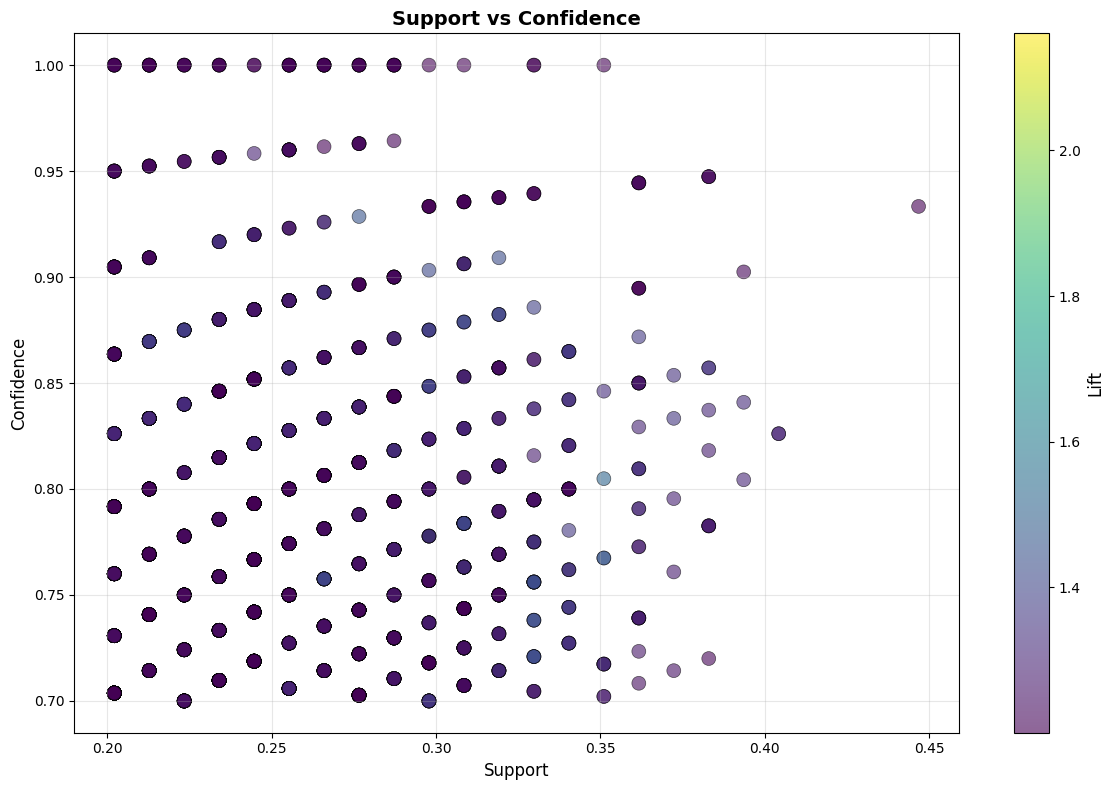

In [17]:
# Scatter plot: Support vs Confidence colored by Lift
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(rules['support'], rules['confidence'], c=rules['lift'], s=100, alpha=0.6, cmap='viridis', edgecolors='black', linewidth=0.5)

ax.set_xlabel('Support', fontsize=12)
ax.set_ylabel('Confidence', fontsize=12)
ax.set_title('Support vs Confidence',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lift', fontsize=12)

plt.tight_layout()
plt.show()

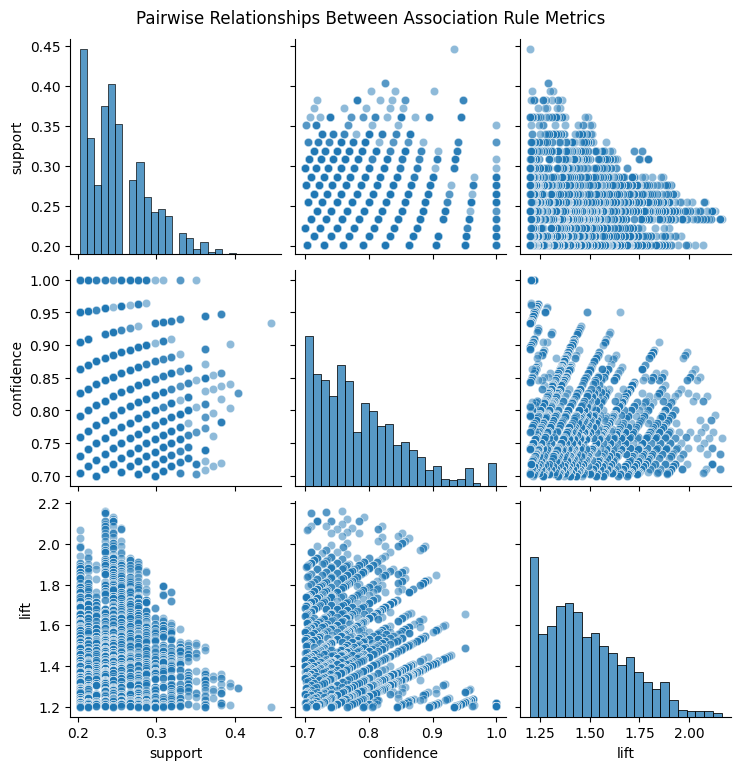

In [18]:
metrics = rules[['support', 'confidence', 'lift']]
metrics_sample = metrics[(rules['lift'] >= 1.2) & (rules['support'] >= 0.15)]

sns.pairplot(metrics_sample, diag_kind='hist', plot_kws={'alpha': 0.5})

plt.suptitle("Pairwise Relationships Between Association Rule Metrics", y=1.02)
plt.show()

## Refinement A: Sensitivity, Stability, and Redundancy Filtering

### Sensativity

In [19]:
# look across different support and confidence combos to see how rule counts change
support_vals = [0.05, 0.08, 0.10, 0.12, 0.15, 0.20]
confidence_vals = [0.50, 0.60, 0.70, 0.80]
lift_cutoff = 1.2

results = []

for s in support_vals:
    freq = apriori(basket, min_support=s, use_colnames=True)
    for c in confidence_vals:
        if len(freq) == 0:
            results.append({'min_support': s, 'min_confidence': c, 'n_itemsets': 0, 'n_rules': 0})
            continue
        r = association_rules(freq, metric="confidence", min_threshold=c)
        r = r[r['lift'] > lift_cutoff]
        results.append({'min_support': s, 'min_confidence': c, 'n_itemsets': len(freq), 'n_rules': len(r)})

sweep_df = pd.DataFrame(results)
display(sweep_df)

,min_support,min_confidence,n_itemsets,n_rules
0,0.05,0.5,3677,28324
1,0.05,0.6,3677,18813
2,0.05,0.7,3677,11143
3,0.05,0.8,3677,5706
4,0.08,0.5,2488,21650
5,0.08,0.6,2488,13458
6,0.08,0.7,2488,6986
7,0.08,0.8,2488,2907
8,0.10,0.5,2068,20120
9,0.10,0.6,2068,12227


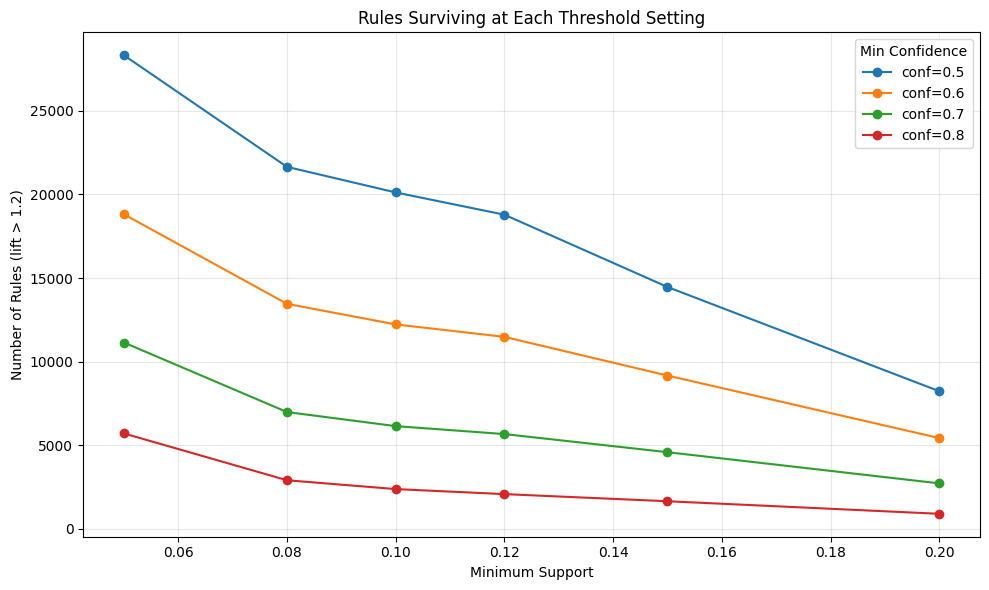

In [20]:
# line chart showing rule count drop-off as I raise support
fig, ax = plt.subplots(figsize=(10, 6))

for c in confidence_vals:
    subset = sweep_df[sweep_df['min_confidence'] == c]
    ax.plot(subset['min_support'], subset['n_rules'], marker='o', label=f'conf={c}')

ax.set_xlabel('Minimum Support')
ax.set_ylabel('Number of Rules (lift > 1.2)')
ax.set_title('Rules Surviving at Each Threshold Setting')
ax.legend(title='Min Confidence')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# run at the loosest setting to get all possible rules
freq_wide = apriori(basket, min_support=0.05, use_colnames=True)
all_rules = association_rules(freq_wide, metric="confidence", min_threshold=0.50)
all_rules = all_rules[all_rules['lift'] > 1.0]

# string key per rule so we can track it across settings
all_rules['rule_key'] = (all_rules['antecedents'].apply(lambda x: tuple(sorted(x))).astype(str) + ' -> '+ all_rules['consequents'].apply(lambda x: tuple(sorted(x))).astype(str))

# count how many of the 24 threshold combos each rule survives
rule_survival = {}

for s in support_vals:
    freq = apriori(basket, min_support=s, use_colnames=True)
    for c in confidence_vals:
        if len(freq) == 0:
            continue
        r = association_rules(freq, metric="confidence", min_threshold=c)
        r = r[r['lift'] > 1.0]
        r['rule_key'] = (r['antecedents'].apply(lambda x: tuple(sorted(x))).astype(str)
                         + ' -> '
                         + r['consequents'].apply(lambda x: tuple(sorted(x))).astype(str))
        for key in r['rule_key']:
            rule_survival[key] = rule_survival.get(key, 0) + 1

total_combos = len(support_vals) * len(confidence_vals)

all_rules['n_settings_survived'] = all_rules['rule_key'].map(rule_survival).fillna(0).astype(int)
all_rules['pct_survived'] = (all_rules['n_settings_survived'] / total_combos * 100).round(1)

stable_rules = (all_rules.sort_values('n_settings_survived', ascending=False).drop_duplicates(subset='rule_key')
[['antecedents','consequents','support','confidence','lift','n_settings_survived','pct_survived']])

print(f"Total combos tested: {total_combos}")
print(f"\nMost persistent rules:")
display(stable_rules.head(15))

print(f"\nFragile rules (1-2 settings only):")
display(stable_rules[stable_rules['n_settings_survived'] <= 2].head(10))

Total combos tested: 24

Most persistent rules:


,antecedents,consequents,support,confidence,lift,n_settings_survived,pct_survived
26127,"(Sleeping bag, Trapping wire, Pot, Multitool)","(Fishing gear, Axe)",0.265957,0.833333,1.017316,24,100.0
26130,"(Trapping wire, Fishing gear, Pot, Multitool)","(Sleeping bag, Axe)",0.265957,0.862069,1.157635,24,100.0
45,(Trapping wire),(Bow and arrows),0.404255,0.826087,1.294203,24,100.0
4,(Ferro rod),(Axe),0.702128,0.857143,1.007143,24,100.0
31,(Bow and arrows),(Fishing gear),0.617021,0.966667,1.009630,24,100.0
79,(Fishing gear),(Pot),0.925532,0.966667,1.009630,24,100.0
80,(Pot),(Fishing gear),0.925532,0.966667,1.009630,24,100.0
34,(Multitool),(Bow and arrows),0.404255,0.826087,1.294203,24,100.0
29,(Bow and arrows),(Ferro rod),0.542553,0.850000,1.037662,24,100.0
38,(Bow and arrows),(Pot),0.617021,0.966667,1.009630,24,100.0



Fragile rules (1-2 settings only):


,antecedents,consequents,support,confidence,lift,n_settings_survived,pct_survived
33557,"(Sleeping bag, Gillnet, Pot, Saw)","(Ferro rod, Rations)",0.085106,0.571429,1.310105,2,8.3
26176,"(Rations, Fishing gear, Axe, Trapping wire, Saw)",(Multitool),0.063830,0.600000,1.226087,2,8.3
26175,"(Rations, Fishing gear, Multitool, Axe, Saw)",(Trapping wire),0.063830,0.600000,1.226087,2,8.3
26186,"(Rations, Sleeping bag, Fishing gear, Axe, Tra...",(Multitool),0.074468,0.636364,1.300395,2,8.3
58177,"(Rations, Ferro rod, Pot, Bow and arrows, Slee...","(Paracord, Fishing gear)",0.053191,0.625000,1.087963,2,8.3
3690,"(Gillnet, Bow and arrows)","(Saw, Multitool)",0.085106,0.533333,1.285470,2,8.3
44609,"(Rations, Sleeping bag, Paracord, Axe, Saw)","(Fishing gear, Knife)",0.063830,0.666667,1.305556,2,8.3
58212,"(Paracord, Rations, Fishing gear, Multitool)","(Sleeping bag, Ferro rod, Pot, Bow and arrows)",0.053191,0.625000,1.198980,2,8.3
54280,"(Rations, Ferro rod, Bow and arrows, Pot, Slee...","(Axe, Trapping wire)",0.053191,0.625000,1.506410,2,8.3
54284,"(Rations, Ferro rod, Bow and arrows, Pot, Axe,...","(Sleeping bag, Multitool)",0.053191,0.625000,1.468750,2,8.3


### Bootstrap Stability

In [22]:
# resample contestants 100 times, re-run apriori each time, track which rules keep showing up
n_bootstraps = 100
boot_counts = {}

np.random.seed(42)

for i in range(n_bootstraps):
    sample = basket.sample(n=len(basket), replace=True)
    freq = apriori(sample, min_support=0.20, use_colnames=True)
    if len(freq) == 0:
        continue
    r = association_rules(freq, metric="confidence", min_threshold=0.70)
    r = r[r['lift'] > 1.2]
    r['rule_key'] = (r['antecedents'].apply(lambda x: tuple(sorted(x))).astype(str)
                     + ' -> '
                     + r['consequents'].apply(lambda x: tuple(sorted(x))).astype(str))
    for key in r['rule_key'].unique():
        boot_counts[key] = boot_counts.get(key, 0) + 1

boot_df = pd.DataFrame([
    {'rule_key': k, 'appearances': v, 'appearance_rate': round(v / n_bootstraps * 100, 1)}
    for k, v in boot_counts.items()
]).sort_values('appearances', ascending=False)

print(f"Rules found in at least 1 bootstrap: {len(boot_df)}")
print(f"\nTop 15 by appearance rate:")
display(boot_df.head(15))

print(f"\nWeak rules (<20% appearance):")
display(boot_df[boot_df['appearance_rate'] < 20].head(10))

Rules found in at least 1 bootstrap: 31694

Top 15 by appearance rate:


,rule_key,appearances,appearance_rate
446,"('Axe', 'Ferro rod', 'Trapping wire') -> ('Bow...",100,100.0
448,"('Axe', 'Sleeping bag', 'Trapping wire') -> ('...",100,100.0
1502,"('Axe', 'Ferro rod', 'Fishing gear', 'Trapping...",100,100.0
1505,"('Axe', 'Fishing gear', 'Sleeping bag', 'Trapp...",100,100.0
2617,"('Ferro rod', 'Fishing gear', 'Pot', 'Trapping...",100,100.0
1703,"('Axe', 'Ferro rod', 'Pot', 'Trapping wire') -...",100,100.0
847,"('Ferro rod', 'Fishing gear', 'Trapping wire')...",100,100.0
3632,"('Axe', 'Fishing gear', 'Pot', 'Sleeping bag',...",99,99.0
186,"('Ferro rod', 'Trapping wire') -> ('Bow and ar...",99,99.0
3627,"('Axe', 'Ferro rod', 'Fishing gear', 'Pot', 'T...",99,99.0



Weak rules (<20% appearance):


,rule_key,appearances,appearance_rate
11546,"('Bow and arrows', 'Multitool', 'Trapping wire...",19,19.0
8815,"('Bow and arrows', 'Multitool', 'Paracord') ->...",19,19.0
8814,"('Bow and arrows', 'Multitool', 'Sleeping bag'...",19,19.0
14611,"('Axe', 'Bow and arrows', 'Fishing gear') -> (...",19,19.0
8779,"('Bow and arrows', 'Ferro rod', 'Multitool', '...",19,19.0
1076,"('Bow and arrows', 'Pot', 'Rations', 'Sleeping...",19,19.0
1081,"('Bow and arrows', 'Paracord', 'Saw') -> ('Mul...",19,19.0
8810,"('Bow and arrows', 'Fishing gear', 'Multitool'...",19,19.0
4368,"('Fishing gear', 'Multitool', 'Pot', 'Trapping...",19,19.0
9899,"('Ferro rod', 'Paracord', 'Trapping wire') -> ...",19,19.0


### Filter Redundancies

In [38]:
# start from baseline rules and clean them up
freq_med = apriori(basket.drop(columns=['cluster']), min_support=0.20, use_colnames=True)
rules_full = association_rules(freq_med, metric="confidence", min_threshold=0.70)
rules_full = rules_full[rules_full['lift'] > 1.2].copy()

print(f"Before filtering: {len(rules_full)} rules")

# catch A->B / B->A duplicates by making a sorted canonical key
rules_full['canonical'] = rules_full.apply(lambda row: tuple(sorted([tuple(sorted(row['antecedents'])), tuple(sorted(row['consequents']))])),axis=1)

# keep the higher-confidence direction for each pair
final_rules = (rules_full.sort_values('confidence', ascending=False).drop_duplicates(subset='canonical', keep='first').sort_values('lift', ascending=False))

print(f"After removing reciprocals: {len(final_rules)} rules")

# drop rules where the antecedent is just a bigger version of a simpler rule
# e.g. {axe, saw}->pot is redundant if {axe}->pot already exists at similar confidence
to_drop = []
for i, row_i in final_rules.iterrows():
    for j, row_j in final_rules.iterrows():
        if i == j:
            continue
        if (row_i['consequents'] == row_j['consequents']
            and row_i['antecedents'] > row_j['antecedents']
            and abs(row_i['confidence'] - row_j['confidence']) < 0.05):
            to_drop.append(i)

final_rules = final_rules.drop(index=set(to_drop))
print(f"After removing redundant supersets: {len(final_rules)} rules")

# attach bootstrap rates from earlier
final_rules['rule_key'] = (final_rules['antecedents'].apply(lambda x: tuple(sorted(x))).astype(str) + ' -> ' + final_rules['consequents'].apply(lambda x: tuple(sorted(x))).astype(str))
final_rules = final_rules.merge(boot_df[['rule_key','appearance_rate']], on='rule_key', how='left')

print(f"\nFinal clean rules:")
display(final_rules[['antecedents','consequents','support','confidence','lift','appearance_rate']].rename(columns={'appearance_rate': 'bootstrap_%'}).reset_index(drop=True))

Before filtering: 2720 rules
After removing reciprocals: 2707 rules
After removing redundant supersets: 477 rules

Final clean rules:


,antecedents,consequents,support,confidence,lift,bootstrap_%
0,"(Sleeping bag, Fishing gear, Bow and arrows, M...","(Ferro rod, Trapping wire, Axe, Pot)",0.234043,0.733333,2.154167,66.0
1,"(Pot, Sleeping bag, Fishing gear, Axe, Trappin...","(Ferro rod, Bow and arrows, Multitool)",0.234043,0.709677,2.151925,56.0
2,"(Ferro rod, Bow and arrows, Multitool)","(Sleeping bag, Trapping wire, Fishing gear, Axe)",0.244681,0.741935,2.113392,78.0
3,"(Ferro rod, Bow and arrows, Multitool)","(Sleeping bag, Trapping wire, Axe, Pot)",0.244681,0.741935,2.113392,77.0
4,"(Ferro rod, Trapping wire, Fishing gear, Axe)","(Sleeping bag, Bow and arrows, Multitool)",0.244681,0.718750,2.111328,58.0
...,...,...,...,...,...,...
472,"(Ferro rod, Trapping wire, Fishing gear, Bow a...","(Sleeping bag, Axe, Pot)",0.287234,0.843750,1.201705,50.0
473,"(Axe, Knife)","(Ferro rod, Fishing gear, Pot)",0.361702,0.894737,1.201504,50.0
474,"(Axe, Knife)","(Sleeping bag, Ferro rod, Fishing gear, Pot)",0.361702,0.894737,1.201504,50.0
475,"(Ferro rod, Fishing gear, Bow and arrows, Saw)","(Paracord, Pot)",0.276596,0.702703,1.200983,32.0


## Refinement B: Clustering by Loadout Archetypes

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

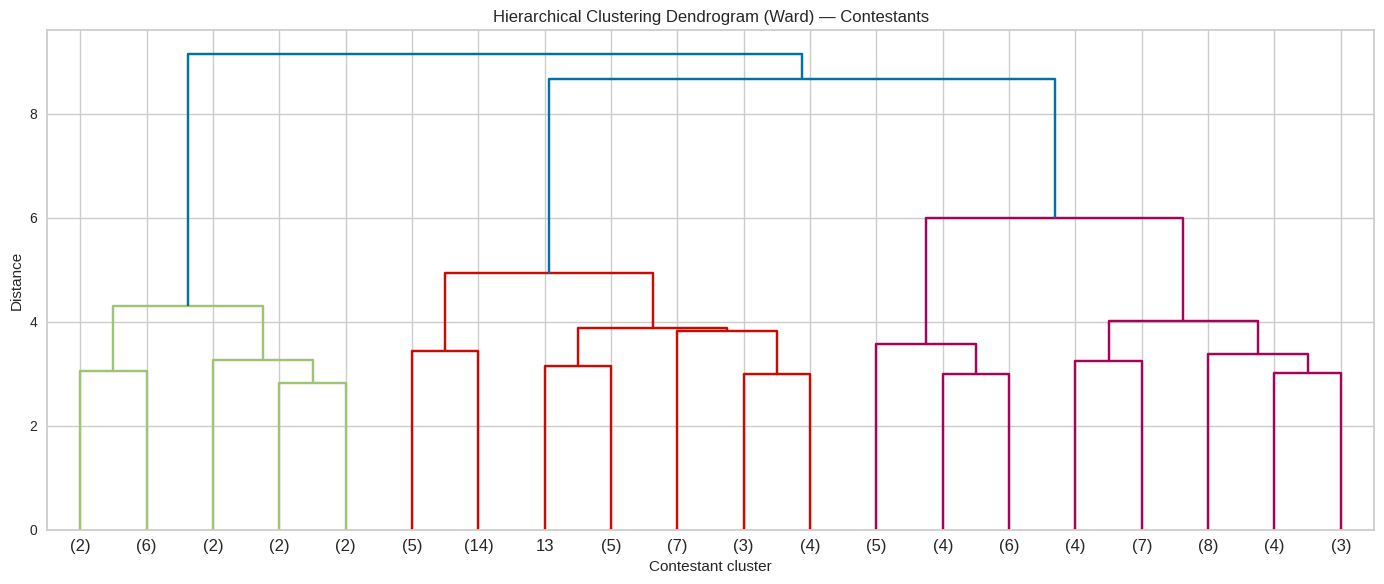

In [25]:
# dendrogram to see groupings
groupingsdendo = linkage(basket, method='ward', metric='euclidean')

fig, ax = plt.subplots(figsize=(14, 6))
dendrogram(groupingsdendo, truncate_mode='lastp', p=20, ax=ax)
ax.set_title('Hierarchical Clustering Dendrogram (Ward) — Contestants')
ax.set_xlabel('Contestant cluster')
ax.set_ylabel('Distance')
plt.tight_layout()
plt.show()

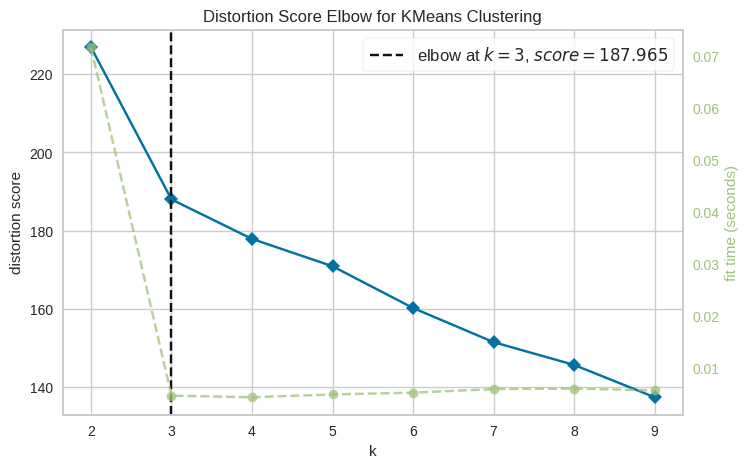

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
# elbow plot to pick k
fig, ax = plt.subplots(figsize=(8, 5))
model = KMeans(random_state=42)
viz = KElbowVisualizer(model, k=(2, 10), ax=ax)
viz.fit(basket)
viz.show()

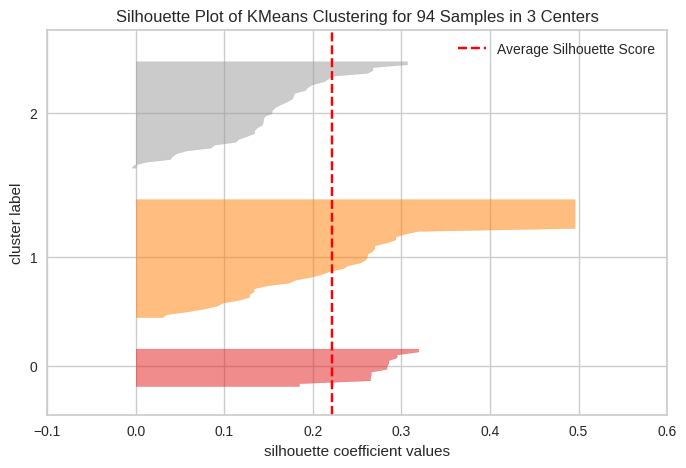

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 94 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [27]:
# silhouette plot at chosen k (adjust k based on elbow result)
k = 3
fig, ax = plt.subplots(figsize=(8, 5))
model = KMeans(n_clusters=k, random_state=42)
viz = SilhouetteVisualizer(model, ax=ax)
viz.fit(basket)
viz.show()

In [30]:
# cluster labels
km = KMeans(n_clusters=k, random_state=42)
basket['cluster'] = km.fit_predict(basket)

# bring in outcome data
basket_profile = basket.join(outcomes)

print(f"Cluster sizes:")
print(basket_profile['cluster'].value_counts().sort_index())

Cluster sizes:
cluster
0    14
1    42
2    38
Name: count, dtype: int64


In [33]:
# top 5 items per cluster
item_cols = [c for c in basket.columns if c != 'cluster']

for clust in sorted(basket_profile['cluster'].unique()):
    sub = basket_profile[basket_profile['cluster'] == clust]
    rates = sub[item_cols].mean().sort_values(ascending=False)
    print(f"\n--- Cluster {clust} (n={len(sub)}) ---")
    print("Top 5 items:")
    print(rates.head(5).round(2).to_string())
    print(f"Avg days lasted: {sub['days_lasted'].mean():.1f}")
    if 'reason_category' in sub.columns:
        print("Tap-out reasons:")
        print(sub['reason_category'].value_counts(normalize=True).round(2).head(3).to_string())


--- Cluster 0 (n=14) ---
Top 5 items:
Fishing gear    1.00
Saw             1.00
Pot             1.00
Tarp            1.00
Rations         0.86
Avg days lasted: 31.4
Tap-out reasons:
reason_category
Family / personal    0.67
Medical / health     0.33

--- Cluster 1 (n=42) ---
Top 5 items:
Sleeping bag    1.00
Ferro rod       0.98
Pot             0.95
Fishing gear    0.90
Multitool       0.90
Avg days lasted: 45.5
Tap-out reasons:
reason_category
Medical / health     0.67
Family / personal    0.31
Loss of inventory    0.03

--- Cluster 2 (n=38) ---
Top 5 items:
Fishing gear    1.00
Knife           1.00
Sleeping bag    1.00
Pot             0.95
Ferro rod       0.95
Avg days lasted: 34.7
Tap-out reasons:
reason_category
Medical / health     0.47
Family / personal    0.47
Loss of inventory    0.06


In [ ]:
# summary table
summary_rows = []
for clust in sorted(basket_profile['cluster'].unique()):
    sub = basket_profile[basket_profile['cluster'] == clust]
    rates = sub[item_cols].mean().sort_values(ascending=False)
    top3 = ', '.join(rates.head(3).index)
    summary_rows.append({'cluster': clust,'n': len(sub),'top_3_items': top3,'avg_days_lasted': round(sub['days_lasted'].mean(), 1),'med_evac_%': round(sub['medically_evacuated'].mean() * 100, 1)
    if 'medically_evacuated' in sub.columns else None})

cluster_summary = pd.DataFrame(summary_rows)
display(cluster_summary)

#### Cluster Interpretations:


1.   Tools heavy kit
2.   Shelter focused kit
3.   Balanced Kit (a little of evrything)

